In [1]:
import pickle
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.spatial.distance import euclidean
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from scipy.spatial.distance import cdist
import umap.umap_ as umap
import matplotlib.colors as mcolors

In [2]:
sp_labels = {0: "Diamond, 3000K",
             1: "Graphite, 3000K",
             2: "0.5 gcc, 1000K",
             3: "1.0 gcc, 2000K",
             4: "2.0 gcc, 6000K",
             5: "3.6 gcc, 6000K",
             6: "3.0 gcc, 8000K",
             7: "Diamond, 300K",
             8: "Graphite, 300K",
             9: "Graphite, 1500K",
             10: "2.0 gcc, 7000K",
             11: "2.5 gcc, 6000K"}

In [3]:
with open("2b_alc_avg_pd_equilibrium.ary", 'rb') as pickle_file:
    avg_pd_2b = pickle.load(pickle_file)

with open("3b_alc_avg_pd_equilibrium.ary", 'rb') as pickle_file:
    avg_pd_3b = pickle.load(pickle_file)

with open("4b_alc_avg_pd_equilibrium.ary", 'rb') as pickle_file:
    avg_pd_4b = pickle.load(pickle_file)

# Combine the arrays along the second axis (axis=1)
combined_array = np.concatenate((avg_pd_2b, avg_pd_3b, avg_pd_4b), axis=1)

# Verify the shape of the combined array
print(combined_array.shape)  # Output will be (12, 180, 1)

# Reshape the array to (12, 60) before creating the DataFrame
reshaped_data = np.array(combined_array).reshape(58,180)

print(reshaped_data.shape)

# Create a DataFrame
avg_df = pd.DataFrame(reshaped_data) # Ground Truth

print(avg_df)

avg_labels = list(range(59)) 

(58, 180, 1)
(58, 180)
         0         1         2         3         4         5         6    \
0   0.138845  0.092964  0.046740  0.078496  0.043927  0.032458  0.019878   
1   0.105789  0.078743  0.067425  0.065861  0.058617  0.050402  0.047386   
2   0.091428  0.067531  0.051034  0.041146  0.036055  0.036478  0.037628   
3   0.093827  0.075693  0.062634  0.053645  0.048352  0.045329  0.043034   
4   0.083775  0.075834  0.068577  0.061975  0.055119  0.049078  0.043958   
5   0.100714  0.083414  0.069838  0.059488  0.051986  0.046035  0.041412   
6   0.064375  0.061167  0.057819  0.054281  0.050697  0.047218  0.043496   
7   0.148263  0.101022  0.036630  0.065748  0.038552  0.037141  0.021178   
8   0.120983  0.076686  0.069101  0.081302  0.066295  0.045733  0.041825   
9   0.112926  0.074743  0.066340  0.071967  0.063659  0.051304  0.046891   
10  0.084348  0.075767  0.068267  0.061104  0.054273  0.048162  0.043017   
11  0.095845  0.080361  0.068713  0.059995  0.053332  0.047898  0

In [4]:
with open("2b_alc_pd.ary", 'rb') as pickle_file:
    pd_2b = pickle.load(pickle_file)

with open("3b_alc_pd.ary", 'rb') as pickle_file:
    pd_3b = pickle.load(pickle_file)

with open("4b_alc_pd.ary", 'rb') as pickle_file:
    pd_4b = pickle.load(pickle_file)

with open("alc_labels", 'rb') as pickle_file:
    labels = pickle.load(pickle_file)

# Initialize master_array
master_array = None

for index, value in enumerate(pd_2b):
    array_2b = value
    array_3b = pd_3b[index]
    array_4b = pd_4b[index]
    all_array = np.concatenate((array_2b, array_3b, array_4b), axis=1)
    #print(np.shape(all_array))
    # Vertically stack all_array to master_array
    if master_array is None:
        master_array = all_array
    else:
        master_array = np.vstack((master_array, all_array))

# Print shape of the master_array
print("Shape of the master array:", master_array.shape)

all_df = pd.DataFrame(master_array)

Shape of the master array: (1116, 180)


Accuracy: 0.9


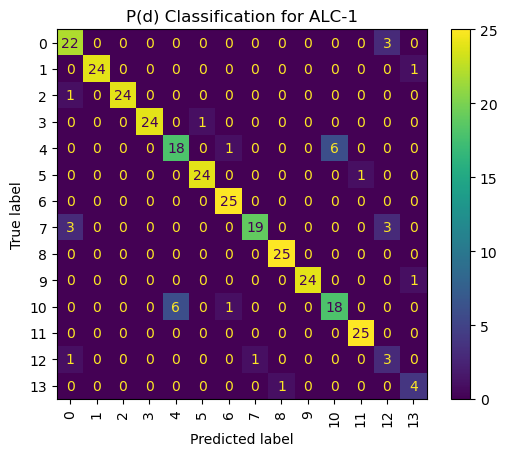

Accuracy: 0.8395061728395061


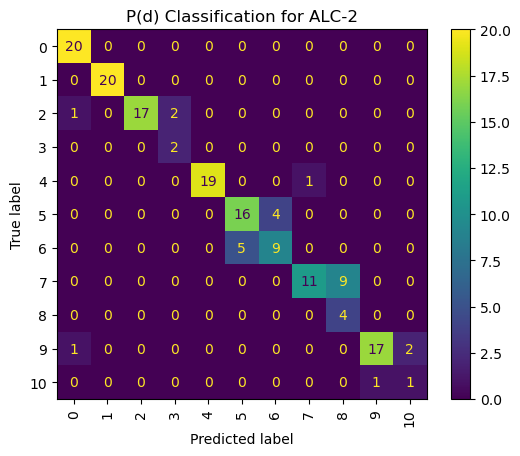

Accuracy: 0.89375


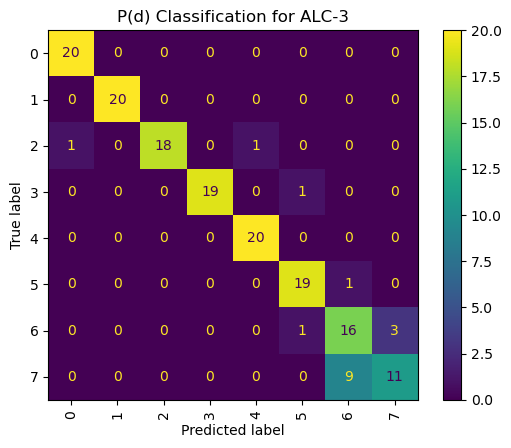

Accuracy: 0.95


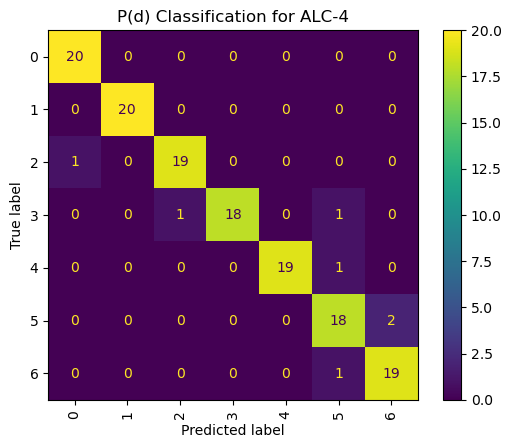

Accuracy: 0.9444444444444444


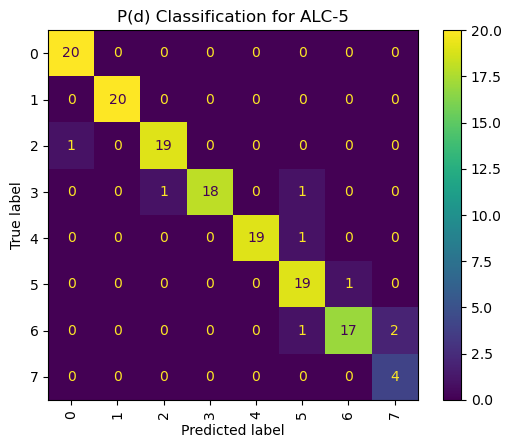

Accuracy: 0.865


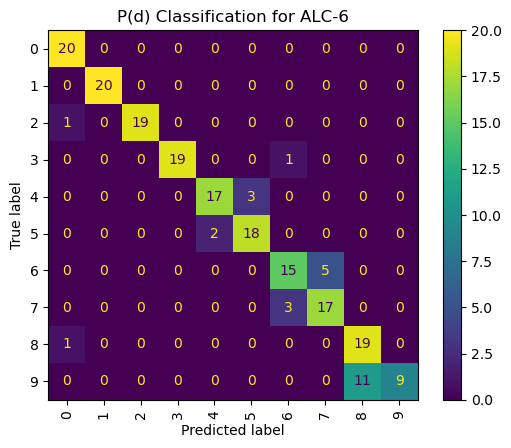

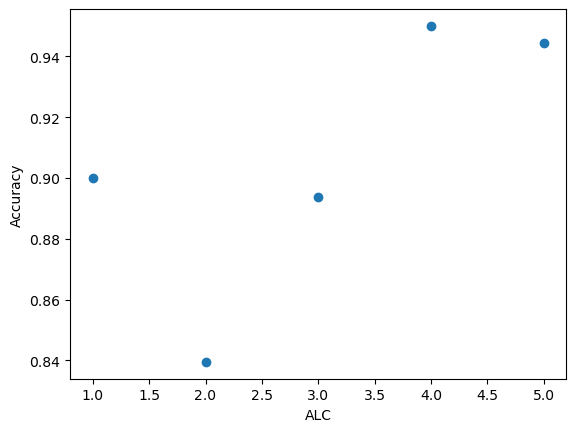

In [5]:
# Define prediction ranges for ALC predictions

# (start frame, end frame, start sp, end sp)
prediction_ranges = [
    (0, 309, 0, 13),   # ALC-1
    (310, 471, 14, 24), # ALC-2
    (472, 631, 25, 32), # ALC-3
    (632, 771, 33, 39), # ALC-4
    (772, 915, 40, 47), # ALC-5
    (916, 1115, 48, 57) # ALC-1 (PBE)
]

alc_cnt = 1
alc_acc = []

for start_frame, end_frame, start_sp, end_sp in prediction_ranges:
    closest_clusters = []
    alc_df = all_df[start_frame:end_frame+1]
    alc_labels = labels[start_frame:end_frame+1]
    alc_avg_df = avg_df[start_sp:end_sp+1]

    for i, row in alc_df.iterrows():
        # Compute distances to all clusters in the original data
        distances_to_clusters = cdist([row], alc_avg_df) # Computes the 2-norm between point and ground truth data
        # Find the index of the closest cluster in the original data
        closest_cluster_index = np.argmin(distances_to_clusters) + start_sp 
        closest_clusters.append(closest_cluster_index)
    # Compute accuracy
    accuracy = accuracy_score(alc_labels, closest_clusters)
    alc_acc.append(accuracy)
    print("Accuracy:", accuracy)

    cm = confusion_matrix(alc_labels, closest_clusters)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(xticks_rotation=90)
    plt.title(f"P(d) Classification for ALC-{alc_cnt}")
    plt.show()
    alc_cnt +=1

plt.scatter(list(range(1, alc_cnt-1)),alc_acc[:-1])
plt.xlabel("ALC")
plt.ylabel("Accuracy")
plt.show()
